In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import signal

import os
import librosa as lb

In [26]:
data_path = './data/labeled_sample/00001073/'

df = pd.read_csv('./data/evaluation.csv')
df.sort_values(by=['audio_file_id'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

patient_id stage_type        audio_file_id  breathing_counts
0        1073    NonREM2  00001073_01_003_002                 1
1        1073    NonREM2  00001073_01_003_003                 5
2        1073    NonREM2  00001073_01_003_004                 3
3        1073    NonREM2  00001073_01_003_005                 2
4        1073    NonREM2  00001073_01_003_006                 2
5        1073    NonREM2  00001073_01_003_007                 4
6        1073    NonREM1  00001073_01_004_001                 6
7        1073    NonREM3  00001073_01_006_010                 3
8        1073        REM  00001073_02_008_008                 4
9        1073        REM  00001073_02_008_009                 4

In [27]:
labels = df['breathing_counts'].values

In [28]:
audio_files = []

for dir_name, _, file_name in os.walk(data_path):
    for file in file_name:
        full_path = os.path.join(dir_name, file)
        audio_files.append(full_path)

audio_files

['./data/labeled_sample/00001073/00001073_01_003_002.wav',
 './data/labeled_sample/00001073/00001073_01_003_003.wav',
 './data/labeled_sample/00001073/00001073_01_003_004.wav',
 './data/labeled_sample/00001073/00001073_01_003_005.wav',
 './data/labeled_sample/00001073/00001073_01_003_006.wav',
 './data/labeled_sample/00001073/00001073_01_003_007.wav',
 './data/labeled_sample/00001073/00001073_01_004_001.wav',
 './data/labeled_sample/00001073/00001073_01_006_010.wav',
 './data/labeled_sample/00001073/00001073_02_008_008.wav',
 './data/labeled_sample/00001073/00001073_02_008_009.wav']

In [34]:
sample_rate = 44100

def load_audio(audio_file):
    output_audio = []
    for file in audio_file:
        audio, _ = lb.load(file, sr=sample_rate)
        output_audio.append(audio)
    return output_audio

audio = load_audio(audio_files)
len(audio)

10

In [213]:
upper_cutoff = 15000
cutoff_freq = [600, upper_cutoff]

high_pass = signal.firwin(401, cutoff_freq, pass_zero= 'bandpass', fs=sample_rate)

def apply_high_pass_filter(sig_array):
    return signal.lfilter(high_pass, [1.0], sig_array)

def apply_log_compression(sig_array, gamma):
    sign = np.sign(sig_array)
    abs_signal = 1 + np.abs(sig_array) * gamma
    logged = np.log(abs_signal)
    scaled = logged * (1 / np.log(1.0 + gamma))
    return sign * scaled

def nomalize_volume(sig_array):
    minAmp, maxAmp = np.amin(sig_array), np.amax(sig_array)
    max_energy = max(abs(minAmp), abs(maxAmp))
    scale = 1.0 / max_energy
    sig_array *= scale
    return sig_array

noise_removed = []

for sig in audio:
    sig = apply_high_pass_filter(sig)
    # sig = apply_log_compression(sig, 0.5)
    # sig = nomalize_volume(sig)
    noise_removed.append(sig)

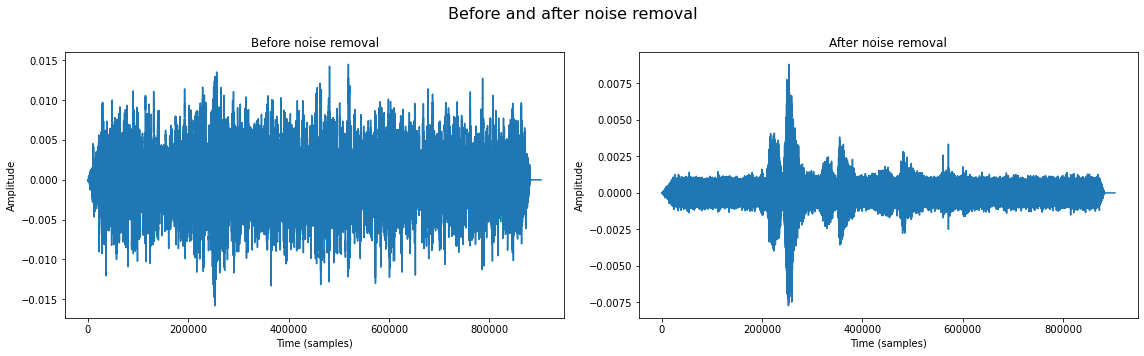

Before noise removal:  (903168,)


After noise removal:  (903168,)


In [214]:
import IPython.display as ipd

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sample_idx = 5

fig.suptitle('Before and after noise removal', fontsize=16)

axs[0].plot(audio[sample_idx])
axs[0].set_title('Before noise removal')

axs[1].plot(noise_removed[sample_idx])
axs[1].set_title('After noise removal')

for ax in axs:
    ax.set_xlabel('Time (samples)')
    ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

print('Before noise removal: ', audio[sample_idx].shape)
ipd.display(ipd.Audio(audio[sample_idx], rate=sample_rate))
print('After noise removal: ', noise_removed[sample_idx].shape)
ipd.display(ipd.Audio(noise_removed[sample_idx], rate=sample_rate))

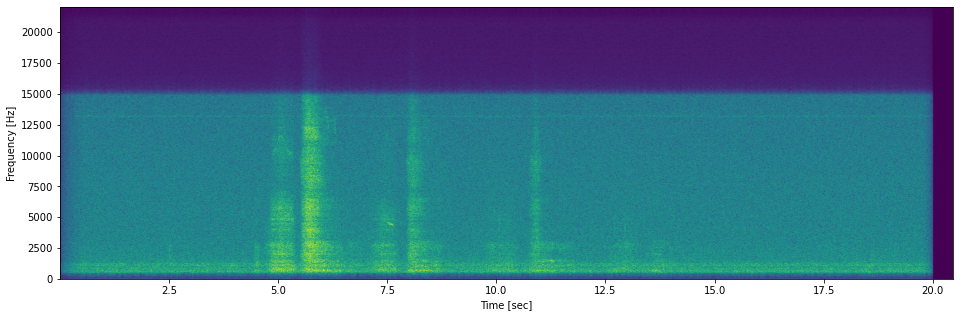

In [215]:
window_size_sec = 0.02
window_size = int(window_size_sec * sample_rate)

def plot_spectrogram(sig_array):
    plt.subplots(figsize=(16, 5))
    plt.pcolormesh(sig_array[1], sig_array[0], np.power(sig_array[2], 0.1), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

def get_spectrogram(sig_array):
    spectrogrmas = []
    for sig in sig_array:
        f, t, Sxx = signal.spectrogram(sig, sample_rate, nperseg=window_size)
        spectrogrmas.append((f, t, Sxx))
    return spectrogrmas

spectrograms = get_spectrogram(noise_removed)
plot_spectrogram(spectrograms[sample_idx])

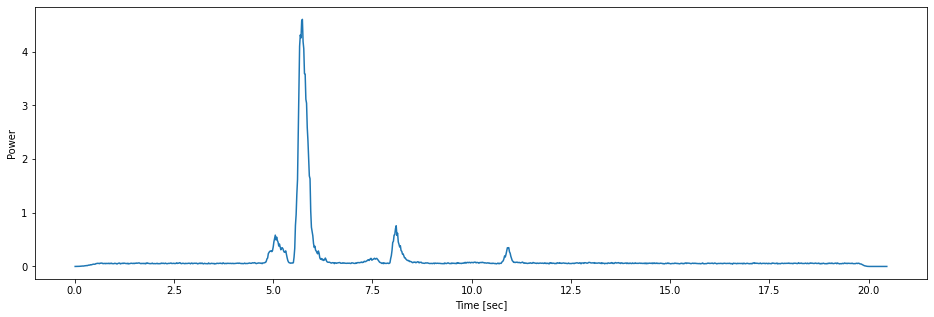

In [216]:
def get_power_envelope(spectrogram, cutoff, plot=False):
    freq = spectrogram[0]
    time = spectrogram[1]
    spectrum = spectrogram[2]

    max_ind = np.sum(freq <= cutoff)
    trunc_freq = freq[:max_ind]

    power_envelop = []

    for idx, _ in enumerate(time):
        power_envelop.append(np.sum(spectrum[:max_ind, idx] * np.square(trunc_freq)))

    if plot:
        plt.subplots(figsize=(16, 5))
        plt.plot(time, power_envelop)
        plt.xlabel('Time [sec]')
        plt.ylabel('Power')
        plt.show()

    return time, power_envelop

time, power_envelop = get_power_envelope(spectrograms[sample_idx], upper_cutoff, plot=True)

In [217]:
import math
from scipy.ndimage import gaussian_filter1d

def find_peak_and_width_from_smoothed_curve(amplitudes, time, sample_interval, min_peak_duration=0.4, gaussian_smoothing_sigma=3, peak_rel_threshold=0.8, plot=False):
    # Gaussian smoothing
    smoothed_curve = gaussian_filter1d(amplitudes, gaussian_smoothing_sigma)

    min_peak_duration_samples = int(math.ceil(min_peak_duration / sample_interval))

    # Find peaks
    peak_indices, _ = signal.find_peaks(smoothed_curve, width=min_peak_duration_samples)

    peak_width_result = signal.peak_widths(smoothed_curve, peak_indices, rel_height=peak_rel_threshold)
    left_peak_times = time[np.rint(peak_width_result[2]).astype(int)]
    right_peak_times = time[np.rint(peak_width_result[3]).astype(int)]
    boundaries = np.stack((left_peak_times, right_peak_times), axis=1)
    peak_timings = time[peak_indices]

    # Find peak width
    peak_widths = []
    for peak_idx in peak_indices:
        peak_widths.append(signal.peak_widths(smoothed_curve, [peak_idx], rel_height=peak_rel_threshold)[0][0])

    # Plot
    if plot:
        plt.subplots(figsize=(16, 5))
        plt.plot(time, amplitudes, color='gray', label='Original')
        plt.plot(time, smoothed_curve, color='red', label='Smoothed')
        plt.plot(peak_timings, smoothed_curve[peak_indices], 'v', color='red', markersize=10, label='Peaks')
        plt.xlabel('Time [sec]')
        plt.ylabel('Power')
        plt.title('Peak detection')
        plt.legend()
        plt.show()

    return smoothed_curve, peak_timings, boundaries

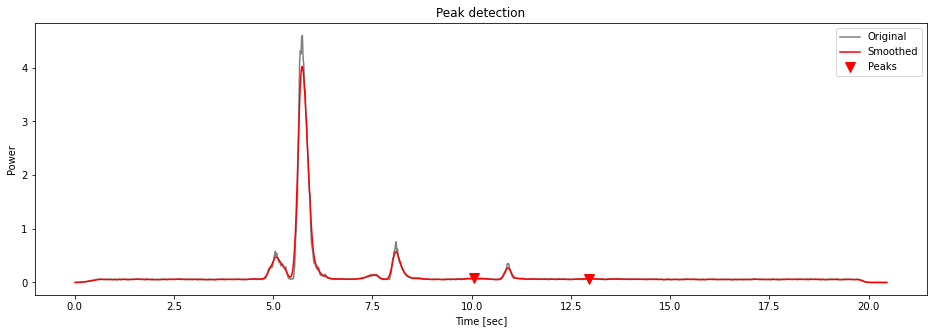

In [218]:
test = find_peak_and_width_from_smoothed_curve(power_envelop, time, window_size_sec, plot=True)